# Visualizing Attention: See what an LLM sees.

In this post, we are going to understand and visualize how attention works in a transformer model. We will see:

- What attention actually does?
- How to extract and visualize attention?
- What different attention heads are doing (or what they specialize in? e.g. syntax or semantics etc)
- Why it matters?

So, when someone says: "*Emily always wanted to visit Paris and she took some ___ lessons in high school*".

You instantly thought "French". But how? You mentally connected Paris → France → French

**LLM does the same** through attention pattern, and we will see how!

## Attention In Action

Before going deep into details, let's see attention in action. The following code gets attention matrices for `distilbert-base-uncased` model and then visualizes a semantic head. We will go in more details to understand attention soon. Don't worry about the code too much!

In [2]:
!pip install -q transformers torch matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [5]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
MODEL_NAME = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)
_ = model.to(device)

print(f"Loaded {MODEL_NAME}")
print(f"  Layers: {model.config.n_layers}")
print(f"  Attention heads per layer: {model.config.n_heads}")
print(f"  Total attention heads: {model.config.n_layers * model.config.n_heads}")

Loaded distilbert-base-uncased
  Layers: 6
  Attention heads per layer: 12
  Total attention heads: 72


In [9]:
def get_attention_maps(text, device, model_name='distilbert-base-uncased'):
  """
  Extract attention weights for all layers and heads

  Returns:
    attentions: List of numpy arrays, shape [batch, num_heads, seq_len, seq_len]
    tokens: List of token strings
  """

  # Load the tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  # Load the model with output_attentions enabled
  config = AutoConfig.from_pretrained(model_name)
  config.output_attentions = True
  model = AutoModel.from_pretrained(model_name, config=config)
  model.eval()

  inputs = tokenizer(text, return_tensors='pt')
  tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

  _ = model.to(device)
  inputs = inputs.to(device)

  with torch.no_grad():
    outputs = model(**inputs)

  # attention is a tuple of length n_layers
  # each element is [batch_size, num_heads, seq_len, seq_len]
  attentions = outputs.attentions
  # get the attention to cpu and convert to numpy
  attentions_np = [attention.cpu().numpy() for attention in attentions]
  return attentions_np, tokens

In [10]:
text = 'Emily always wanted to visit Paris so she took some French lessons'
attentions, tokens = get_attention_maps(text, device)

So, we have the attention map. One of the attention head might be capturing semantic relationship between tokens and will be best to visualize. Let's find and get it.

In [11]:
def find_semantic_connection_head(text, token1, token2, device, model_name='distilbert-base-uncased'):
  """Finds which head shows the strongest connection between two tokens
  Returns:
    (layer_idx, head_idx, attention_weight)
  """
  attentions, tokens = get_attention_maps(text, device)

  idx1 = tokens.index(token1.lower())
  idx2 = tokens.index(token2.lower())

  best_score = 0
  best_head = (0, 0)

  for layer_idx, layer_attn in enumerate(attentions):
    num_heads = layer_attn.shape[1]
    for head_idx in range(num_heads):
      attn_matrix = layer_attn[0, head_idx]

      # check both directions
      score = max(attn_matrix[idx1, idx2], attn_matrix[idx2, idx1])

      if score > best_score:
        best_score = score
        best_head = (layer_idx, head_idx)

  return best_head, best_score

In [12]:
best_head, score = find_semantic_connection_head(text, "paris", "french", device)

print(f"Best head for Paris→French connection:")
print(f"   Layer {best_head[0]}, Head {best_head[1]}")
print(f"   Attention weight: {score:.4f}")

Best head for Paris→French connection:
   Layer 1, Head 10
   Attention weight: 0.7680


Ok! we found the semantic attention head, let's write some code to plot it.

In [13]:
def plot_attention_head(attention_matrix, tokens, layer_num, head_num, figsize=(10, 8)):
  """
  Plot attention heatmap for a specific layer and head
  Args:
    attention_matrix: [seq_len, seq_len] numpy array
    tokens: list of token strings
    layer_num: layer index
    head_num: Head index
  """

  fig, ax = plt.subplots(figsize=figsize)

  sns.heatmap(attention_matrix,
              xticklabels=tokens,
              yticklabels=tokens,
              cmap='RdYlGn',
              cbar_kws={'label': 'Attention Weight'},
              square=True,
              linewidths=0.5,
              ax=ax,
              vmin=0,
              vmax=1)

  ax.set_title(f'Attention Pattern - Layer {layer_num}, Head {head_num}',
                 fontsize=14, pad=15)
  ax.set_xlabel('Attending TO these tokens (Keys) →', fontsize=11)
  ax.set_ylabel('← Attending FROM these tokens (Queries)', fontsize=11)

  # Rotate labels and center them for better alignment
  plt.xticks(rotation=45, ha='center')
  plt.yticks(rotation=0)

  plt.tight_layout()
  plt.show()

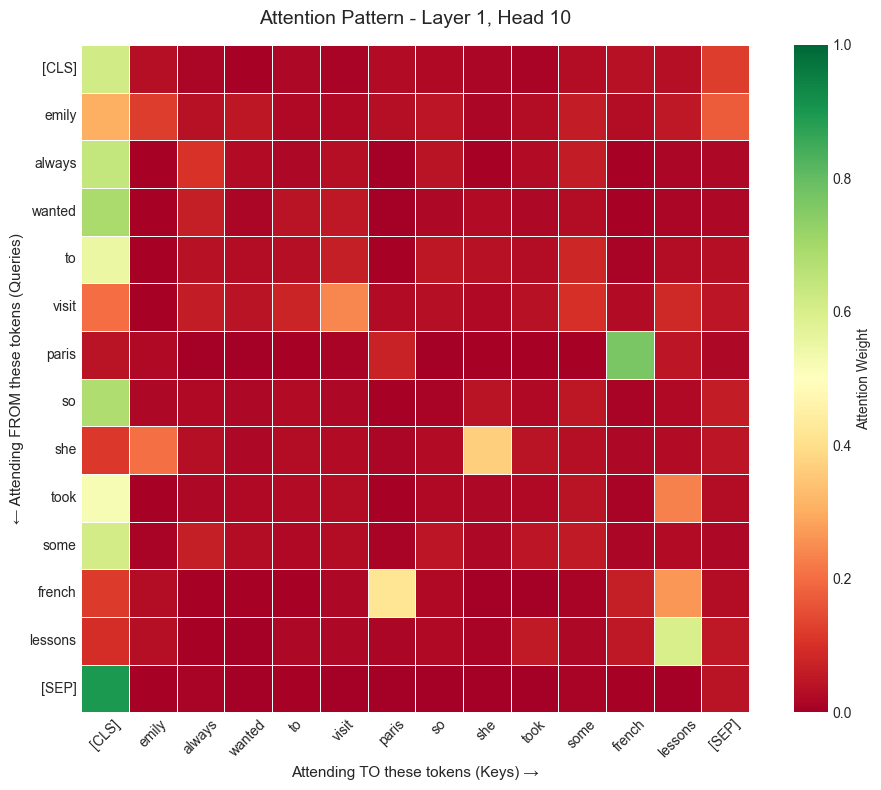

In [15]:
plot_attention_head(attentions[best_head[0]][0, best_head[1]], 
  tokens, best_head[0], best_head[1])

## What This Attention Pattern Reveals

Awesome, quite revealing. Let's decode this heatmap. This heatmap shows when building the representation for token i (row), how the model assigns attention weight to token j (column).

**How to read it?**
- Each row = one word in the sentence
- Each columns = all the words it can "look at".
- Brighter (greener) shades: "I am paying more attention to this word".

### What Model Discovered?

1. **"paris" → "french" (that lighter green cell)**
When the model processes "paris", it's looking at "french" to understand the context. It learned that Paris relates to the French language!

2. **"french" → "lessons" (the bright green cell)**
The "french" row strongly attends to lessons. The model connects these concepts. French is something you take lessons in.

3. **"she" → "emily" (faint orange on the left)**
The "she" row has faint orange color for "emily". The model figured out the pronoun reference.

4. **"Self-Attention in action**
You can see some shades of orange for the cases when token attends to itself. "visit" → "visit" and "she" → "she".

5. **Most cells are dark red**
This means that model is being very selective. It only lights up meaningful connection."always" doesn't need to look at "french" → stays dark. "paris" doesn't need to look at "took" → stays dark.

## Attention 101: The Core Idea

We just saw attention in action. It is connecting "paris" → "french", but what is happening under the hood. We'll explore that in this section. First, why did we need attention mechanism at the first place.

### The Problem Attention Solves
Before transformers, the Recurrent Neural Networks (RNN) were state of the art models for natural language processing task. But they had a problem, imagine you are reading a book one word at a time, but you can only remember summary of everything you have read so far, but not the exact words. RNN worked like that:

```
Input: Emily always wanted to visit Paris so she took some French lessons
Step 1: Process "Emily"      → hidden state h1
Step 2: Process "always"      → hidden state h2 (based on h1)
Step 3: Process "wanted"      → hidden state h3 (based on h2)
...
```
**The Bottleneck**
- By step 6, the model has to remember: "Emily always wanted to visit" in a single vector (h5).
- Long-distance dependencies: Information gets *compressed* through these multiple steps and retrieval gets really worse with longer text. The model *forgets*.
- Serial Processing is very slow, and thus we can't parallelize!

**Attention Solution** : Instead of relying on this compressed representation, what if each token can look at another token directly. No information compression needed!

### The Query, Key and Value Vectors

Attention uses three different perspectives on each word. Imagine you are at a Computer Science conference and you want to connect with machine learning experts to talk to!. This is your *query*: "I am looking for ML experts". Each person wears a badge in the room ("Front End Developer", "Cloud Architect", "Machine Learning Researcher"). These name badges become their *key*. The actual insights each ML expert shares with with you becomes the *value*.  

So you scan the name badges (compare your query of "Machine Learning" to their keys - badges). Found someone? Spend some time with them (high attention weight). Then finally you get their insights (Values) weighted by relevance.

Attention works exactly like this, each word:
- Has a Query: "What am I looking for?"
- Has a Key: "What do I represent?"
- Has a Value: "What do I contribute to others?"

### Mathematics of Attention

#### 1. Query (Q) : What am I looking for?

$$ 
Q = \text{token\_embedding} \times W_q
$$
- `token_embedding`: Base representation of the token from lookup table.
- $W_q$: Learned projection matrix (turns embeddings into queries).

**Example - Processing "Paris":**
- Base embedding: *[geography: 0.8, culture: 0.9, language: 0.3, ...]*
- After $W_q$ projection: *[need_location: 0.9, need_context: 0.7, need_language: 0.8, ...]*

**Interpretation:** "I'm looking for geographic and linguistic context!"
- Note that, this is hypothetical representation, we don't really know what each index of the embedding represents, but this is represented for simplicity.

#### 2. Key (K): "What do I represent?"

$$ K = \text{token\_embedding} \times W_k $$

**Example - For "french":**
- Base embedding: *[language: 0.9, european: 0.7, culture: 0.6, ...]*
- After W_K projection: *[am_language: 0.95, am_european: 0.8, ...]*

**Interpretation:** "I represent a European language!"

#### 3. Value (V): "What information do I carry?"

This is the actual semantic content that gets mixed into other tokens' representations.

#### Why separate matrices?
- Query = Active search (what you want)
- Key = Passive identity (what you are)
- Value = Content to share (what you give)

These are **different roles** for the same base embedding using different transformations!

#### The Formula Explained

Let's re-examine the core attention formula:

$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V $$

Here's what each part means:

-   **$Q$ (Query Matrix)**: This matrix is derived from the query vectors ($Q_{\text{token}}$) of all tokens in the sequence. Each row corresponds to a token's query. It asks: "What information am I looking for from other tokens?"

-   **$K$ (Key Matrix)**: This matrix is derived from the key vectors ($K_{\text{token}}$) of all tokens in the sequence. Each column (or row, depending on convention) corresponds to a token's key. It answers: "What information do I represent?"

-   **$V$ (Value Matrix)**: This matrix is derived from the value vectors ($V_{\text{token}}$) of all tokens in the sequence. Each row corresponds to a token's value. It provides: "What content do I contribute if I'm attended to?"

-   **$Q K^T$ (Dot Product of Query and Key Transpose)**: This performs a dot product between every query vector and every key vector. It computes a similarity score for each possible pair of tokens. A high score means the query token finds the key token relevant to what it's searching for. This results in a matrix of raw attention scores.

-   **$\sqrt{d_k}$ (Scaling Factor)**: $d_k$ is the dimension of the key vectors (and query vectors, they are typically the same). We divide the dot products by the square root of $d_k$. This scaling prevents the dot product values from becoming too large, which can push the `softmax` function into regions with very small gradients, making learning difficult (vanishing gradients).

-   **$\text{softmax}(\dots)$ (Normalization)**: The `softmax` function is applied row-wise to the scaled attention scores. It converts these raw scores into probabilities, ensuring that for each query token, the attention weights to all other tokens sum up to 1. These probabilities represent how much attention each query token pays to every other key token.

-   **$\text{softmax}(\dots) V$ (Weighted Sum of Values)**: Finally, these normalized attention weights are multiplied by the Value matrix $V$. For each token, its new representation is a weighted sum of the value vectors of all tokens in the sequence, where the weights are the attention probabilities calculated in the previous step. This means a token's new representation primarily incorporates information from tokens it paid high attention to.

Let's break this down step by step using *paris* as an example.

#### Step 1: Compute Compatibility Scores ($Q.K^T$)
"paris" has a query vector. Compare it against *all* tokens.

```python
score(paris→emily)  = Q_paris · K_emily   # Dot product
score(paris→wanted) = Q_paris · K_wanted
score(paris→to)     = Q_paris · K_to
score(paris→visit)  = Q_paris · K_visit
score(paris→paris)  = Q_paris · K_paris  # Self!
...
```
**High Score**: Your key matches what I am looking for!

Say, we get something like this as scores

```python
score(paris→emily)  = 15.2
score(paris→wanted) = 8.3
score(paris→to)     = 2.1
score(paris→visit)  = 42.7 # High (travel context)
score(paris→paris)  = 89.4 # High (self-attention)
...
```

#### Step 2: Scale by $\sqrt{d_k}$
We do this scaling to prevent large values from dominating softmax. In DistilBert $d_k = 64$ (dimension of key vectors) and thus $\sqrt{d_k} = 8$.

```python
scaled_score(paris→emily)  = 15.2 / 8 = 1.90
scaled_score(paris→wanted) = 8.3 / 8 = 1.04
scaled_score(paris→to)     = 2.1 / 8 = 0.26
scaled_score(paris→visit)  = 42.7 / 8 = 5.34
scaled_score(paris→paris)  = 89.4 / 8 = 11.18
...
```

If we didn't scale, the softmax scores become skewed

**Without Scaling**
```python
softmax([89.4, 42.7, 15.2, ...]) ≈ [0.99, 0.01, 0.00, ...]
```

**With Scaling**
```python
softmax([11.18, 5.34, 1.90, ...]) ≈ [0.63, 0.25, 0.08, ...]
```

#### Step 3: Softmax → Probabilities

Convert scores into a probability distribution (sums to 1.0):
```python
attention_weights = softmax([1.90, 1.04, 0.26, 5.34, 11.18])
                  = [0.08, 0.03, 0.01, 0.25, 0.63]
```

**Interpretation - "Paris attends to:"**

- emily:   8%  (minor - the person)
- wanted:  3%  (barely relevant)
- to:      1%  (minimal)
- visit:  25%  (important - travel context!)
- paris:  63%  (mostly self-attention)
- ...

Note that, this is exactly one row in our heatmap.

#### Step 4: Weighted Sum of Values ($V$)

Collect information based on attention weights:
```python
Output_paris = 0.08·V_emily + 0.03·V_wanted + 0.01·V_to
             + 0.25·V_visit + 0.63·V_paris + ...
```

**Result:** "Paris" representation now contains:
- 63% of its own meaning
- 25% of visit's travel context
- 8% of Emily's person/subject info

**This enriched vector** goes to the next layer!

### Why This Design Works So Well!

#### 1. Parallel Processing
Remember, in RNN, we could only process token sequentially to compute the compressed state for next token. However, in attention, we could do all the computation at once for each token (All dot products in one matrix multiply). This also suits really well to massively parallel GPUs (built for it). We get 100x or more speed!

#### 2. No More Single-Vector Bottleneck Across Time
In recurrent models, information must be passed forward through a single hidden state at every time step. This creates an inherent bottleneck as sequences grow longer, the hidden state is repeatedly overwritten, making it difficult to preserve long-range dependencies without loss.

Self-attention removes this constraint. Instead of compressing the entire past into one vector, each token can directly attend to any other token in the sequence within a single layer. This allows long-range interactions to be modeled explicitly, without relying on information to survive many sequential transformations.

### Summary

To summarize, we looked at attention mechanism with simple examples.

Is actually four simple steps:
1. Compare queries to keys ($Q·K^T$)
2. Scale to prevent explosion ($/\sqrt{d_k}$)
3. Turn into probabilities (softmax)
4. Use these weights for getting the values ($V$)

In the end, we get each word's representation which is enriched with context from words it attended to. The heatmap we saw was the attention matrix after step 3 (softmax).

## Multi-Head Attention: 12 Perspectives

**Why 12 heads in DistilBERT?**. Instead of relying on just one head, almost all model architectures relies on multiple attention heads. Why? Well, to learn different kinds of relationships between tokens. One attention head might be looking at semantic relationship, other might be looking at co-reference, and other might be looking at grammatical syntax and so on.
```python
Head 1:  W_Q₁, W_K₁, W_V₁  → Learns syntax
Head 2:  W_Q₂, W_K₂, W_V₂  → Learns semantics
...
Head 12: W_Q₁₂, W_K₁₂, W_V₁₂ → Learns other patterns

```

Also, The best part of this design is that we can run all different multi-head attention computation in parallel. In the end, we combine the heads to gain the global relationship between tokens from various perspectives.

```python

`MultiHead = Concat(head₁, ..., head₁₂) · Wo`
```

Let's visualize and compare three different attention heads for our Emily sentence.










In [37]:
def compare_three_heads(text, attentions, tokens, device='cpu', layer_idx=4):
    """Compare 3 heads side-by-side"""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    head_indices = [0, 5, 10]
    head_names = ['Head 0', 'Head 5', 'Head 10']

    for idx, head_idx in enumerate(head_indices):
      attn = attentions[layer_idx][0, head_idx]
      sns.heatmap(attn,
                  xticklabels=tokens,
                  yticklabels=tokens if idx == 0 else [],
                  cmap='RdYlGn',
                  square=True,
                  ax=axes[idx],
                  vmin=0,
                  vmax=0.5,
                  cbar_kws={'label': 'Attention'})

      axes[idx].set_title(head_names[idx], fontsize=13)
      plt.setp(axes[idx].get_xticklabels(), rotation=45, ha='center')

    plt.suptitle(f'Layer {layer_idx}: Three Different Attention Patterns\n"{text}"',
                 fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

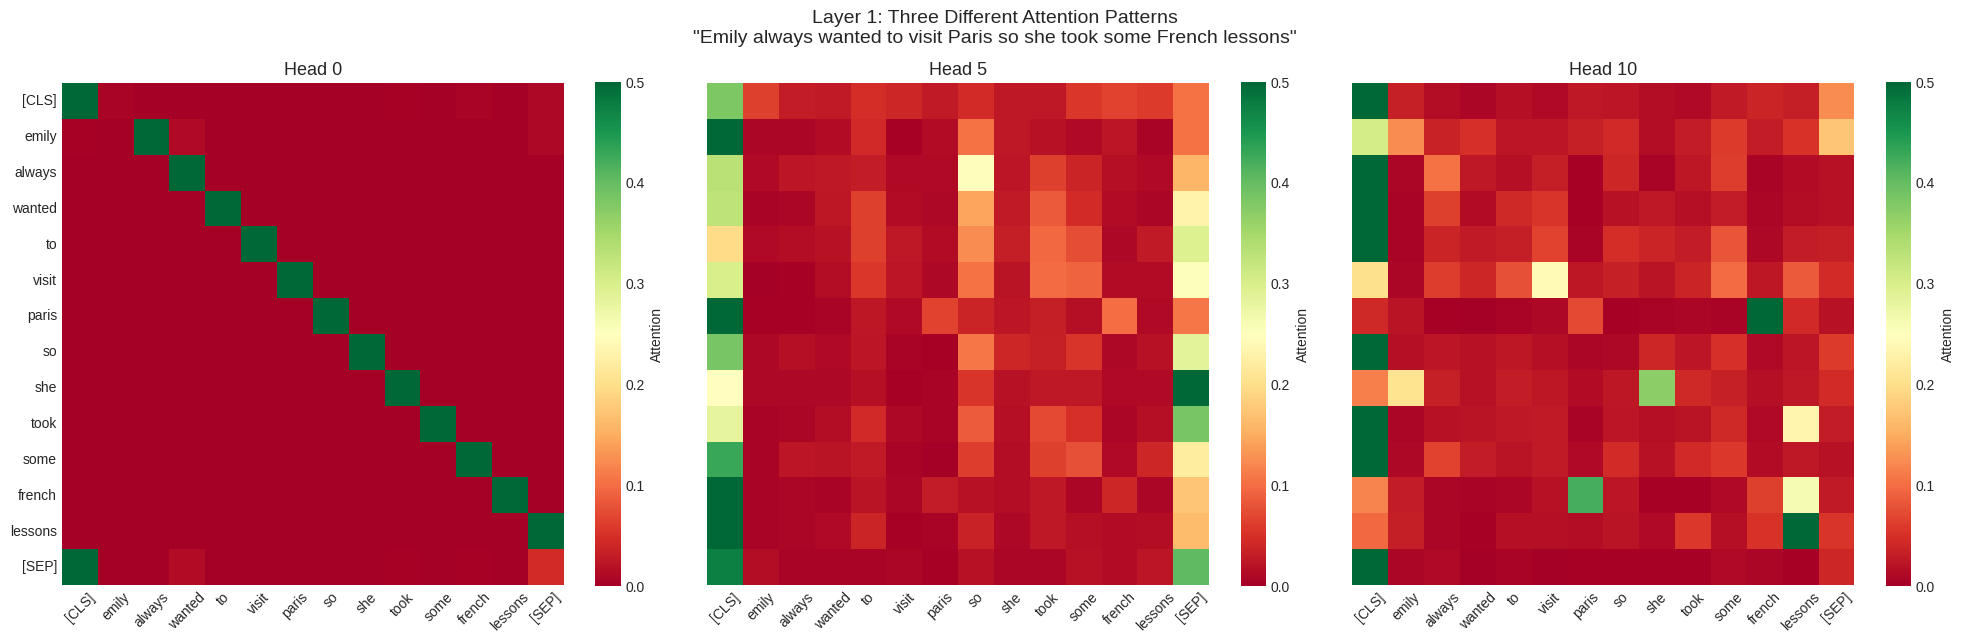

In [45]:
compare_three_heads(text, attentions, tokens, layer_idx=1)

Very fascinating results! We have same sentence, same layer, but **three radically different attention patterns**. Let's interpret these heads one by one. Remember that dark red represents not so relevant, while darkgreen represents higher relevance.

One more thing to note is that attention heads are often polyfunctional and input-dependent. Although below, I assign a role to head, but that is only for learning purpose.

---

#### Head 0 (Left):

This head appears to be doing simple positional bookkeeping. There is a perfect bright green diagonal running from top-left to bottom-right. Everything else is dark red (near 0 attention). So each token is almost exclusively attending to itself. It preserves each token's representation through the layer without mixing context from other tokens. It acts like a "skip connection" through the attention layer and maintains token identity.

---

#### Head 5 (Middle):

As compared to head 0, this one has more diffused patterns (oranges and light red spread out). It has no clear diagonal thus weak self-attention, while attention is more distributed across token. Remember that attention head need not to be specialized.

- "always → "so"
- "paris" → "french"

We can hypothesize this head spreads attention broadly to **integrate context from the full sentence**. It builds holistic understanding (not just local patterns)
and likely creates sentence-level representations

---

#### Head 10 (Right):

This head is more **selective** than Head 5 (more dark red). It has specific connections light up (yellowish and green spots in strategic places)

- "paris" → "french"
- "french" → "paris"
- "she" → "emily"
- "french" → "lessons"
- "took" → "lessons"

We can hypothesize this head finds **meaningful semantic relationships** between concepts.

**The big idea:** Multi-head attention is like having many different experts analyzing the same sentence: a grammarian, a semanticist, a position tracker, etc. The final understanding combines all their insights! This diversity of multi-head attention makes it amazingly powerful.


## Conclusion

We can summarize our key learnings:

1. **Attention is a learned lookup mechanism**:  When we see "paris" attending to "french" it was not programmed explicitly. The model **learned** this geographic-linguistic connection from reading millions of sentences during pre-training.

2. **The Attention Mechanism (Q, K, V)**

Attention computes three things for each token:
- **Query (Q):** "What am I looking for?"
- **Key (K):** "What do I represent?"
- **Value (V):** "What information do I carry?"

**The formula:** Attention(Q,K,V) = softmax(Q·K^T/√d_k)·V

**In practice:**
- Q·K^T: Compare queries to keys (compatibility scores)
- Scaling: Prevent softmax saturation
- Softmax: Convert to probabilities
- ·V: Weighted sum of values


3. **Multi-Head Attention = Multiple Specialists**: We saw how different heads learn completely different concepts and bring different perspectives on the same token connections.

4. **Heads are multi-talented**: Attention heads are not rigidly specialized. A semantic head may also learn useful positional patterns and vice versa. Model optimizes for one thing: to **minimize loss**. Heads learn whatever combination of patterns achieves this. This flexibility makes transformers adaptable through fine-tuning!

